# 전기차 충전소 최적 입지 선정
- import
- preprocessing
- 분석

# import

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.cluster import KMeans
from sklearn.metrics import recall_score as rc

In [66]:
print('numpy version: ',np.__version__)
print('pandas version: ',pd.__version__)
print('scikit-learn version: ',sklearn.__version__)
print('matplotlib version: ',matplotlib.__version__)
print('seaborn version: ',sns.__version__)
print('joblib version: ',joblib.__version__)

numpy version:  1.23.4
pandas version:  1.5.1
scikit-learn version:  1.1.3
matplotlib version:  3.5.3
seaborn version:  0.12.0
joblib version:  1.1.1


# preprocessing

In [67]:
# 생성한 최종 데이터 셋 불러오기
df=pd.read_csv('final_2/final_of_final.csv')

C:\Users\ggyo0\AppData\Local\Temp\ipykernel_1316\1678232928.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('final_2/final_of_final.csv')


## 결측치 처리

In [68]:
# nan -> 0
df.fillna(0,inplace=True)

In [69]:
# 분석에 사용되지 않는 경도,위도,행정구역,분류 컬럼 제거
df.drop(['경도_Lng','위도_Lat','행정구역','분류'],axis=1,inplace=True)

## label encoding

In [70]:
encoder=LabelEncoder()

# 문자열 값 인코딩
# encoder.fit(df['행정구역'].astype(str))
# df['행정구역']=df['행정구역'].astype(str)
# df['행정구역']=encoder.transform(df['행정구역'])

df['statNm']=df['statNm'].astype(str)
df['statNm']=encoder.fit_transform(df['statNm'])

### 예측할 label 컬럼 생성

In [71]:
charger_lst=[]

for nm in tqdm(df['statNm']):
    if nm!=0:
        charger_lst.append('T')
    else:
        charger_lst.append('F')

df['충전기 유무']=charger_lst

100%|██████████| 97945/97945 [00:00<00:00, 838872.79it/s]


In [72]:
# 분석에 사용하지 않을 statNm 컬럼 삭제
df.drop('statNm',axis=1,inplace=True)

In [73]:
# T,F 값 인코딩
encoder.fit(df['침수우려여부'])

df['침수우려여부']=encoder.transform(df['침수우려여부'])
df['cctv 유무']=encoder.transform(df['cctv 유무'])
df['지진 발생']=encoder.transform(df['지진 발생'])
df['충전기 유무']=encoder.transform(df['충전기 유무'])

In [74]:
df.head(1)

,경도_Lng-위도_Lat,침수우려여부,합산 검색 수,내국인 관광객수,외국인 관광객수,지진 발생,cctv 유무,2020교통량,2021교통량,전년대비 증감대수,...,2021경제활동인구,2022경제활동인구,2122인구증감율,2122경제활동인구증감율,2021전기차,2022전기차,2021전기차비율,2022전기차비율,2122전기차증감율,충전기 유무
0,126.356_33.347,0,0.0,0.0,0.0,0,0,67346.0,71122.0,3776.0,...,12946.0,13583.0,-0.85,4.92,839.0,1064.0,6.42,8.1,26.82,1


## 정규화

In [75]:
scaler=MinMaxScaler()
# scaler2=StandardScaler()

In [76]:
# 스케일링 하지 않을 경도-위도 컬럼은 다시 인덱스화
df.set_index('경도_Lng-위도_Lat',inplace=True)

In [77]:
df.head(1)

,침수우려여부,합산 검색 수,내국인 관광객수,외국인 관광객수,지진 발생,cctv 유무,2020교통량,2021교통량,전년대비 증감대수,전년대비 증감율(%),...,2021경제활동인구,2022경제활동인구,2122인구증감율,2122경제활동인구증감율,2021전기차,2022전기차,2021전기차비율,2022전기차비율,2122전기차증감율,충전기 유무
경도_Lng-위도_Lat,,,,,,,,,,,,,,,,,,,,,
126.356_33.347,0,0.0,0.0,0.0,0,0,67346.0,71122.0,3776.0,5.61,...,12946.0,13583.0,-0.85,4.92,839.0,1064.0,6.42,8.1,26.82,1


In [78]:
# feature, label 분리
feature=df[df.columns[:-1]]
label=df['충전기 유무']

In [79]:
feature.head(1)

,침수우려여부,합산 검색 수,내국인 관광객수,외국인 관광객수,지진 발생,cctv 유무,2020교통량,2021교통량,전년대비 증감대수,전년대비 증감율(%),...,2022인구,2021경제활동인구,2022경제활동인구,2122인구증감율,2122경제활동인구증감율,2021전기차,2022전기차,2021전기차비율,2022전기차비율,2122전기차증감율
경도_Lng-위도_Lat,,,,,,,,,,,,,,,,,,,,,
126.356_33.347,0,0.0,0.0,0.0,0,0,67346.0,71122.0,3776.0,5.61,...,21063.0,12946.0,13583.0,-0.85,4.92,839.0,1064.0,6.42,8.1,26.82


In [80]:
feature.columns

Index(['침수우려여부', '합산 검색 수', '내국인 관광객수', '외국인 관광객수', '지진 발생', 'cctv 유무',
       '2020교통량', '2021교통량', '전년대비 증감대수', '전년대비 증감율(%)', '2021인구', '2022인구',
       '2021경제활동인구', '2022경제활동인구', '2122인구증감율', '2122경제활동인구증감율', '2021전기차',
       '2022전기차', '2021전기차비율', '2022전기차비율', '2122전기차증감율'],
      dtype='object')

In [78]:
# standard scaler를 사용할 컬럼 추출
# index_1=list(df.columns[:4])+list(df.columns[7:9])
# feature.columns[:4],feature.columns[7:9]
# index_1

In [81]:
# minmax scaler를 사용할 컬럼 추출
index_2=(list(feature.columns[1:4])+list(feature.columns[6:]))
index_2

['합산 검색 수',
 '내국인 관광객수',
 '외국인 관광객수',
 '2020교통량',
 '2021교통량',
 '전년대비 증감대수',
 '전년대비 증감율(%)',
 '2021인구',
 '2022인구',
 '2021경제활동인구',
 '2022경제활동인구',
 '2122인구증감율',
 '2122경제활동인구증감율',
 '2021전기차',
 '2022전기차',
 '2021전기차비율',
 '2022전기차비율',
 '2122전기차증감율']

### 정규화한 결과를 데이터프레임화 하여 concat

In [82]:
feature_2=feature[index_2]

In [83]:
df_scaled=pd.DataFrame(scaler.fit_transform(feature_2),index=df.index,columns=index_2)

In [84]:
df_scaled.head(1)

,합산 검색 수,내국인 관광객수,외국인 관광객수,2020교통량,2021교통량,전년대비 증감대수,전년대비 증감율(%),2021인구,2022인구,2021경제활동인구,2022경제활동인구,2122인구증감율,2122경제활동인구증감율,2021전기차,2022전기차,2021전기차비율,2022전기차비율,2122전기차증감율
경도_Lng-위도_Lat,,,,,,,,,,,,,,,,,,
126.356_33.347,0.0,0.0,0.0,0.24357,0.244711,0.276893,0.484701,0.055766,0.055287,0.058144,0.05762,0.280973,0.635659,0.058135,0.057629,0.785802,0.820669,0.890143


In [85]:
feature_scaled=pd.concat([feature.drop(index_2,axis=1),df_scaled],axis=1)
# label=label.reset_index().drop('경도_Lng-위도_Lat',axis=1)

## 상관계수 분석

In [86]:
# matplotlib 한글 사용을 위한 코드

matplotlib.rcParams['font.family']='Malgun Gothic' # 한글 폰트 세팅 (맑은 고딕)
matplotlib.rcParams['font.size']=12 # 폰트 크기 세팅
matplotlib.rcParams['axes.unicode_minus']=False # 유니코드가 - 기호로 설정되는 것을 방지

In [87]:
feature_scaled.columns

Index(['침수우려여부', '지진 발생', 'cctv 유무', '합산 검색 수', '내국인 관광객수', '외국인 관광객수',
       '2020교통량', '2021교통량', '전년대비 증감대수', '전년대비 증감율(%)', '2021인구', '2022인구',
       '2021경제활동인구', '2022경제활동인구', '2122인구증감율', '2122경제활동인구증감율', '2021전기차',
       '2022전기차', '2021전기차비율', '2022전기차비율', '2122전기차증감율'],
      dtype='object')

In [95]:
# 상관관계 분석의 원활한 시각화를 위해 컬럼 순서 재배치

corr_lst=list(feature_scaled.columns[:6])+list(feature_scaled.columns[8:10])+list(feature_scaled.columns[14:16])+list(feature_scaled.columns[18:])
corr_lst2=list(feature_scaled.columns[6:8])+list(feature_scaled.columns[10:14])+list(feature_scaled.columns[16:18])

feature_scaled_new=feature_scaled[corr_lst+corr_lst2]

<AxesSubplot:>

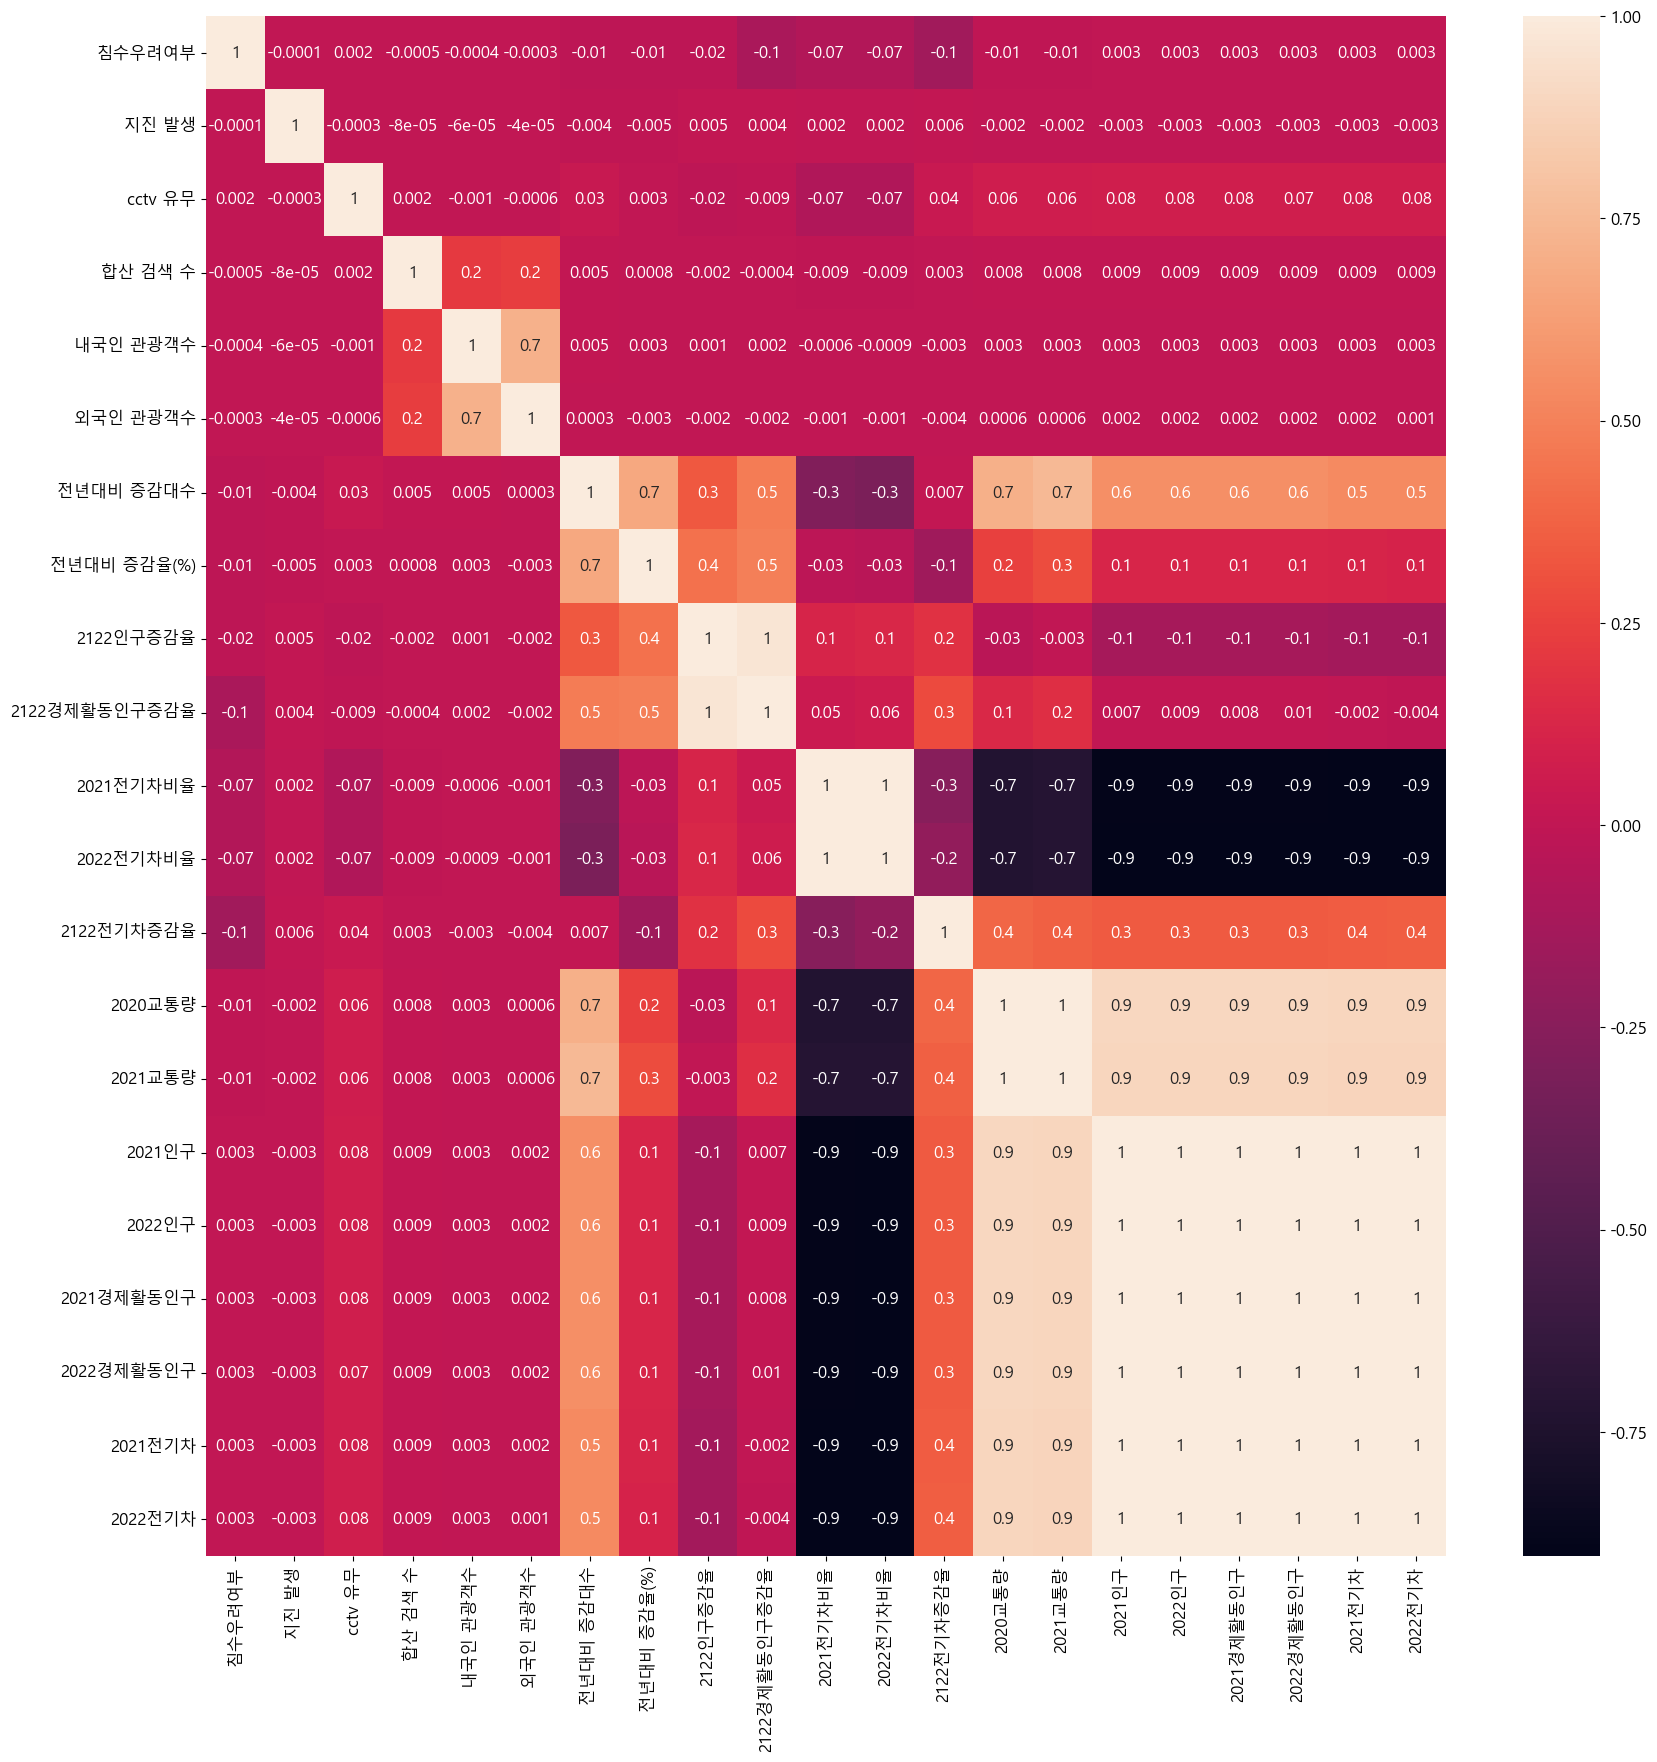

In [97]:
plt.figure(figsize=(20,20))
sns.heatmap(feature_scaled_new.corr(),annot=True, fmt='.1g')

## 주성분 분석 & 차원 압축

In [99]:
pca=PCA(n_components=2)

# 상관계수가 높았던 열 사용
cols=list(feature_scaled_new.columns[-8:])

print('대상 속성명:',cols)
pca.fit(feature_scaled_new[cols])

# 압축한 component 2개로 99퍼 이상의 변동성 설명 가능 확인
print('PCA Component 별 변동성:',pca.explained_variance_ratio_)

대상 속성명: ['2020교통량', '2021교통량', '2021인구', '2022인구', '2021경제활동인구', '2022경제활동인구', '2021전기차', '2022전기차']
PCA Component 별 변동성: [0.96371632 0.03601015]


In [109]:
# 차원압축할 컬럼 분리 & 압축(2개년 통계_1, 2개년 통계_2)
fsn_1=feature_scaled_new[feature_scaled_new.columns[:13]]

fsn_2=feature_scaled_new[feature_scaled_new.columns[-8:]]
fsn_2=pca.fit_transform(fsn_2)

In [125]:
# 압축한 컬럼을 데이터프레임화
fsn_2_df=pd.DataFrame(fsn_2,index=fsn_1.index,columns=['2개년 통계_1','2개년 통계_2'])

In [130]:
fsn_2_df.head(1)

,2개년 통계_1,2개년 통계_2
경도_Lng-위도_Lat,,
126.356_33.347,-0.622198,-0.037425


In [127]:
fsn_final=pd.concat([fsn_1,fsn_2_df],axis=1)

In [129]:
fsn_final.head(1)

,침수우려여부,지진 발생,cctv 유무,합산 검색 수,내국인 관광객수,외국인 관광객수,전년대비 증감대수,전년대비 증감율(%),2122인구증감율,2122경제활동인구증감율,2021전기차비율,2022전기차비율,2122전기차증감율,2개년 통계_1,2개년 통계_2
경도_Lng-위도_Lat,,,,,,,,,,,,,,,
126.356_33.347,0,0,0,0.0,0.0,0.0,0.276893,0.484701,0.280973,0.635659,0.785802,0.820669,0.890143,-0.622198,-0.037425


In [131]:
display(fsn_final.head(1),label.head(1))

,침수우려여부,지진 발생,cctv 유무,합산 검색 수,내국인 관광객수,외국인 관광객수,전년대비 증감대수,전년대비 증감율(%),2122인구증감율,2122경제활동인구증감율,2021전기차비율,2022전기차비율,2122전기차증감율,2개년 통계_1,2개년 통계_2
경도_Lng-위도_Lat,,,,,,,,,,,,,,,
126.356_33.347,0,0,0,0.0,0.0,0.0,0.276893,0.484701,0.280973,0.635659,0.785802,0.820669,0.890143,-0.622198,-0.037425


경도_Lng-위도_Lat
126.356_33.347    1
Name: 충전기 유무, dtype: int32

In [134]:
# 전처리가 끝난 데이터셋을 csv파일로 저장
pd.concat([fsn_final,label],axis=1).to_csv('final_of_final_preprocessing.csv',index=False)

## train_test split

In [135]:
# label을 기준으로 충전기가 설치된 곳과 설치되지 않은곳을 추출
df_df=pd.concat([fsn_final,label],axis=1)

In [137]:
df_train_1=df_df[df_df['충전기 유무']==1]

In [138]:
# random으로 충전기가 설치되어 있는 지역과 같은 개수의 충전기가 설치되어 있지 않은 지역의 데이터 추출
df_train_2=df_df[df_df['충전기 유무']==0].sample(950)

In [142]:
df_train=pd.concat([df_train_1,df_train_2])

In [144]:
# 학습 데이터 feature, label 분리
feature_tr=df_train[df_train.columns[:-1]]
label_tr=df_train['충전기 유무']

# 분석 - 분류모델

## train

In [149]:
# random forest classifier 사용
# gridsearchcv를 사용하여 최적의 파라미터 값 사용
model=rfc(random_state=42)

params={
    'n_estimators':[50,100,200,300],
    'max_features':['auto','sqrt','log2'],
    'max_depth':[4,5,6,7,8],
    'criterion':['gini','entropy']
}

In [150]:
cv_rfc=GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='recall', refit=True)

In [152]:
cv_rfc.fit(feature_tr,label_tr)

c:\work\Miniconda\envs\tf_env\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\work\Miniconda\envs\tf_env\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\work\Miniconda\envs\tf_env\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='recall')

In [153]:
print('best parameters:',cv_rfc.best_params_)
print('best score:',round(cv_rfc.best_score_,2))

best parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 50}
best score: 0.62


In [154]:
# pd.DataFrame(cv_rfc.cv_results_)

In [155]:
# 최적의 파라미터로 학습시킨 모델(random forest classifier) 사용
estimator=cv_rfc.best_estimator_

In [324]:
df_df_3=df_df.reset_index().set_index(['index','경도_Lng-위도_Lat'])

## predict

In [160]:
x_final=df_df[df_df.columns[:-1]]
y_final=df_df['충전기 유무']

In [161]:
pred=estimator.predict(x_final)
print('recall:',rc(y_final,pred))

recall: 0.8115789473684211


## 예측 결과 중 모델이 전기차 충전소가 있다고 예측했지만 실제로는 충전소가 없었던 지역만 추출

In [162]:
df_pred=pd.DataFrame(pred,index=x_final.index,columns=['충전기 유무'])

In [165]:
df_real=pd.DataFrame(y_final,columns=['충전기 유무'])

In [173]:
df_clustering=df_real[np.logical_and(df_real['충전기 유무']==0,df_pred['충전기 유무']==1)]

In [174]:
df_clustering.head()

,충전기 유무
경도_Lng-위도_Lat,
126.531_33.361,0
126.532_33.361,0
126.533_33.361,0
126.534_33.361,0
126.535_33.361,0


# 분석 - 군집화

In [172]:
# 군집화에 사용될 경도-위도 컬럼을 제외한 나머지 컬럼 제거
clustering_df=df_clustering.reset_index().drop('충전기 유무',axis=1)

In [177]:
# 경도-위도 컬럼을 경도,위도 컬럼으로 분할하고 데이터프레임화
clustering_df_final=pd.DataFrame(clustering_df['경도_Lng-위도_Lat'].str.split('_').tolist(),columns=['경도','위도'])

In [179]:
clustering_df_final.head()

,경도,위도
0,126.531,33.361
1,126.532,33.361
2,126.533,33.361
3,126.534,33.361
4,126.535,33.361


## train

In [181]:
# kmeans클러스터링 사용

kmeans=KMeans(n_clusters=5, init='k-means++', max_iter=200, random_state=42)
cluster_labels=kmeans.fit_predict(clustering_df_final)

clustering_df_final['kmean_labels']=cluster_labels

In [184]:
# 플롯에 사용될 제주도 위도 경도 데이터
jj=df_df.reset_index()[['경도_Lng-위도_Lat']]
jj=pd.DataFrame(jj['경도_Lng-위도_Lat'].str.split('_').to_list(),columns=['경도','위도'])

## predict

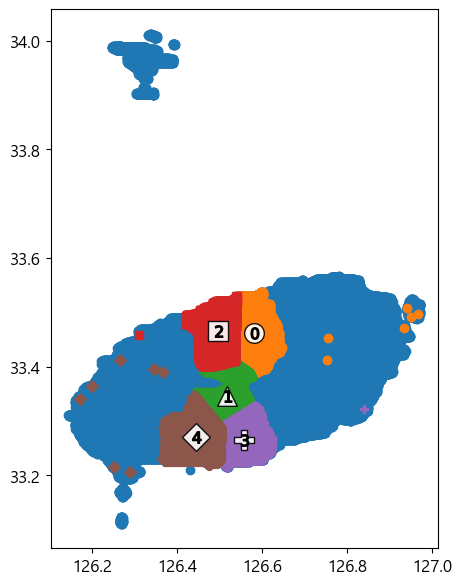

In [186]:
centers=kmeans.cluster_centers_
unique_labels=np.unique(cluster_labels)

markers=['o','^','s','P','D','H','x']

plt.figure(figsize=(5,7))
plt.scatter(jj['경도'].astype(float),jj['위도'].astype(float))
for label in unique_labels:
    label_cluster=clustering_df_final[clustering_df_final['kmean_labels']==label]
    center_x_y=centers[label]

    plt.scatter(x=label_cluster['경도'].astype(float),
                y=label_cluster['위도'].astype(float),
                marker=markers[label])

    plt.scatter(x=center_x_y[0],y=center_x_y[1], s=200, color='white', alpha=.9, edgecolor='k',marker=markers[label])
    plt.scatter(x=center_x_y[0],y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)
plt.show()

In [187]:
# 군집들의 중심점 반환
centers

array([[126.57995368,  33.46179154],
       [126.51615066,  33.3463638 ],
       [126.49538631,  33.46535737],
       [126.55603654,  33.26493715],
       [126.44437843,  33.27086495]])

In [188]:
clustering_df_final

,경도,위도,kmean_labels
0,126.531,33.361,1
1,126.532,33.361,1
2,126.533,33.361,1
3,126.534,33.361,1
4,126.535,33.361,1
...,...,...,...
39925,126.589,33.511,0
39926,126.487,33.49,2
39927,126.596,33.49,0
39928,126.54,33.492,0


# 모델 저장

In [189]:
joblib.dump(estimator, './rfc.pkl')
joblib.dump(kmeans, './km.pkl')

['./km.pkl']

In [191]:
joblib.load('./rfc.pkl')

RandomForestClassifier(max_depth=4, max_features='auto', n_estimators=50,
                       random_state=42)

<AxesSubplot:>

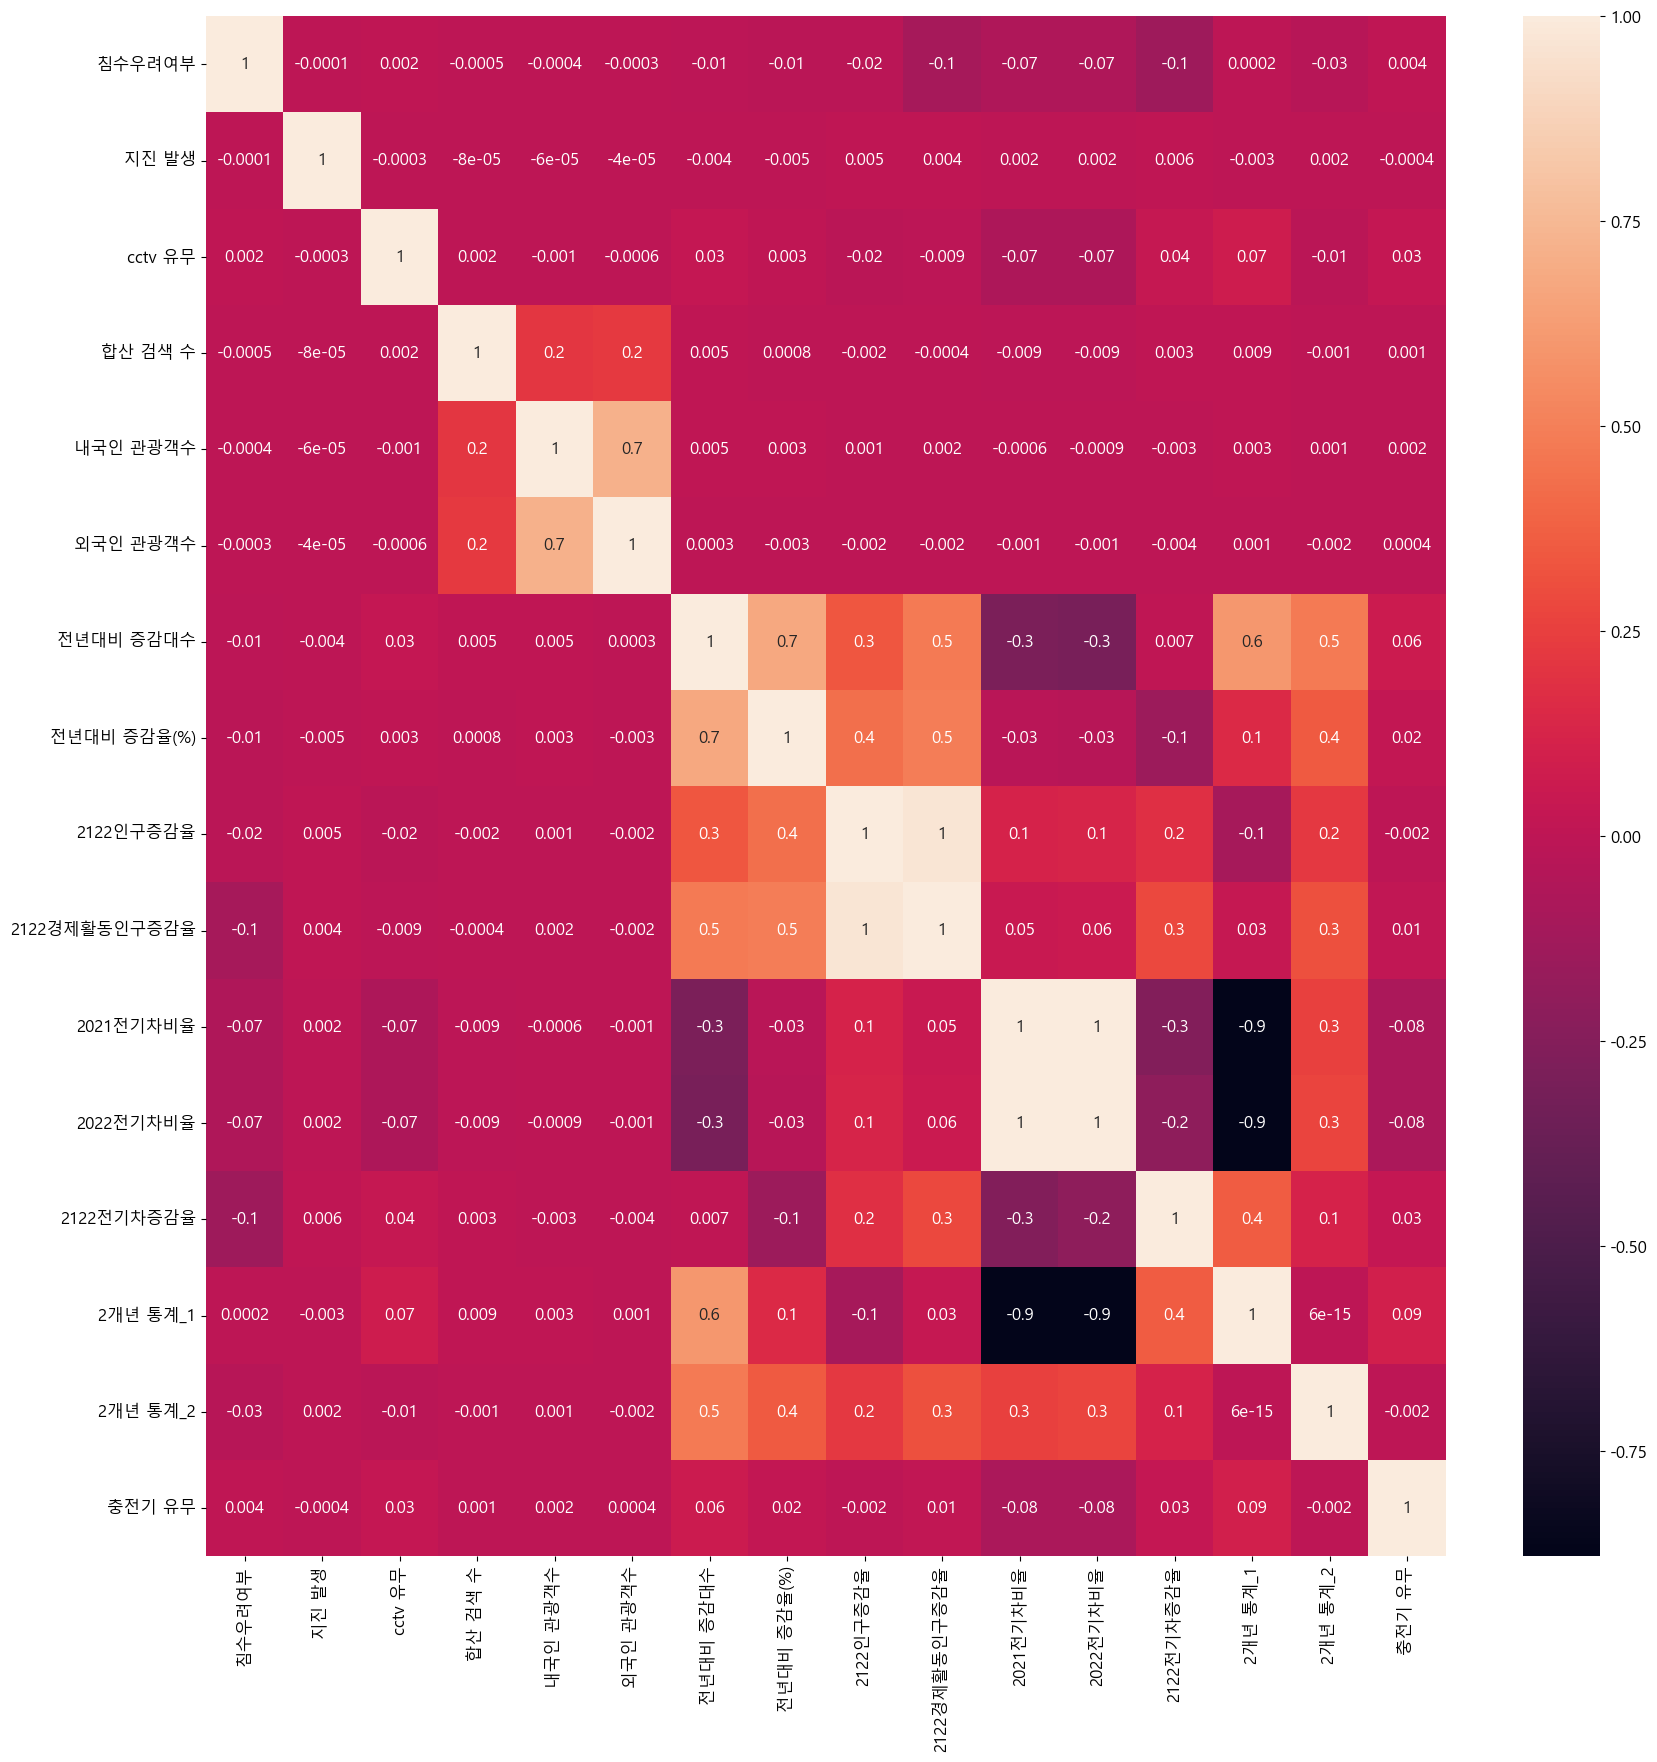

In [192]:
plt.figure(figsize=(20,20))
sns.heatmap(df_df.corr(),annot=True, fmt='.1g')